# Exercise 1: SGD vs GD on a Simple 1D Regression Problem

This notebook implements solutions for the 1D Linear Regression exercise, comparing Stochastic Gradient Descent (SGD), Mini-batch GD, and Full Gradient Descent.

## 1. Setup and Data Generation

$$x^{(i)} = \frac{i}{N}, \quad y^{(i)} = 2x^{(i)} + 1 + \epsilon^{(i)}, \quad \epsilon^{(i)} \sim \mathcal{N}(0, 0.01)$$
$$N=200$$

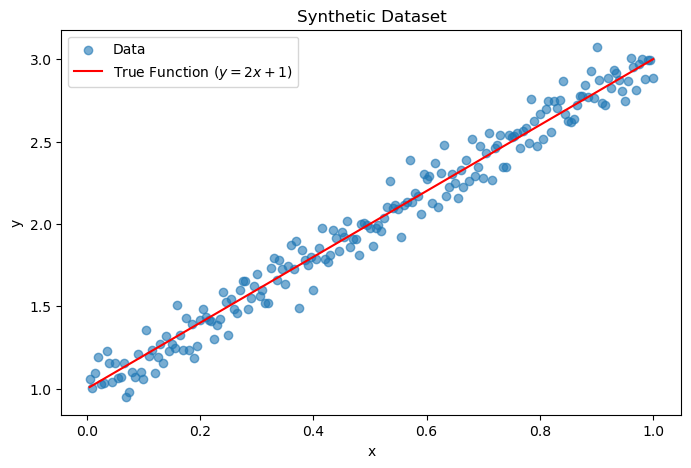

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N = 200
theta_true = np.array([1, 2]) # True parameters [bias, slope]

# Generate Data
# i ranges from 1 to N
i = np.arange(1, N + 1)
X = i / N
noise = np.random.normal(0, np.sqrt(0.01), N) # Variance 0.01 -> std_dev = 0.1
y = theta_true[0] + theta_true[1] * X + noise

# Add bias term to X for vectorized operations: X_b = [1, x]
X_b = np.c_[np.ones((N, 1)), X] # Shape (200, 2)
y = y.reshape(-1, 1) # Shape (200, 1)

# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label='Data')
plt.plot(X, theta_true[0] + theta_true[1]*X, color='red', label='True Function ($y=2x+1$)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Dataset')
plt.legend()
plt.show()

2. Implement MSE Loss and Gradient Descent
Mean Squared Error (MSE) loss function:
$$\mathcal{L}(\Theta) = \frac{1}{N} \sum_{i=1}^{N} (f_{\Theta}(x^{(i)}) - y^{(i)})^2$$


In [21]:
def compute_mse_loss(X_b, y, theta):
    """
    Computes Mean Squared Error.
    X_b: Input data with bias term (N, 2)
    y: Target values (N, 1)
    theta: Parameters (2, 1)
    """
    m = len(y)
    predictions = X_b @ theta
    loss = (1/m) * np.sum((predictions - y)**2)
    return loss

def train_gradient_descent(X_b, y, batch_size, start_theta, learning_rate=0.1, epochs=50):
    m = len(y)
    # USE THE PASSED STARTING POINT (Use copy() so we don't overwrite it)
    theta = start_theta.copy() 
    
    loss_history = []
    theta_history = [theta.copy()]
    
    n_batches = int(np.ceil(m / batch_size))
    
    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X_b[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, m)
            xi = X_shuffled[start_idx:end_idx]
            yi = y_shuffled[start_idx:end_idx]
            
            gradients = (2/len(yi)) * xi.T.dot(xi.dot(theta) - yi)
            theta = theta - learning_rate * gradients
            theta_history.append(theta.copy())
        
        current_loss = compute_mse_loss(X_b, y, theta)
        loss_history.append(current_loss)
        
    return np.array(loss_history), np.array(theta_history)

In [22]:
common_start_theta = np.zeros((2, 1)) 

results = {}
batch_sizes = [1, 10, 50, 200]

# --- 3. Train all models using that SAME starting point ---
for bs in batch_sizes:
    losses, thetas = train_gradient_descent(X_b, y, batch_size=bs, start_theta=common_start_theta)
    results[bs] = {'loss': losses, 'theta': thetas}

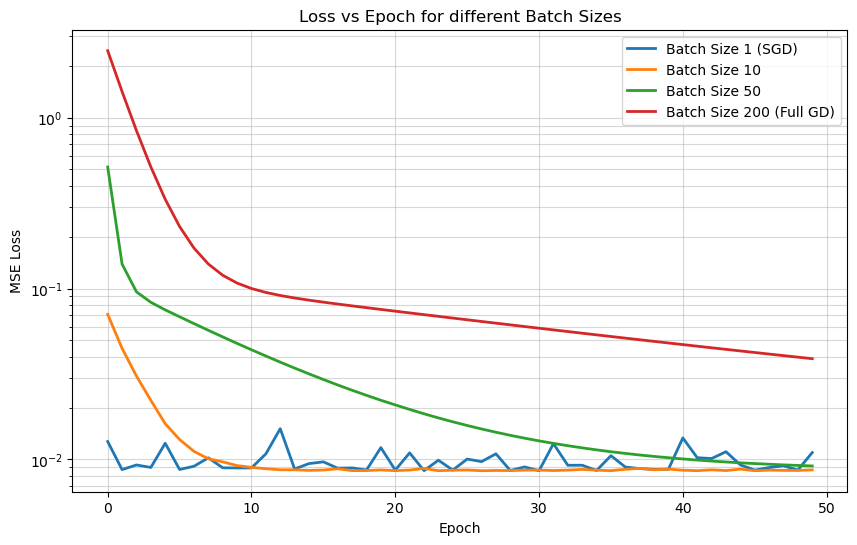

In [23]:
# Plotting

plt.figure(figsize=(10, 6))

for bs in batch_sizes:
    label = f'Batch Size {bs}'
    if bs == 1: label += ' (SGD)'
    if bs == 200: label += ' (Full GD)'
    
    plt.plot(results[bs]['loss'], label=label, linewidth=2)

plt.title('Loss vs Epoch for different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log') # Log scale helps differentiate convergence speeds
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

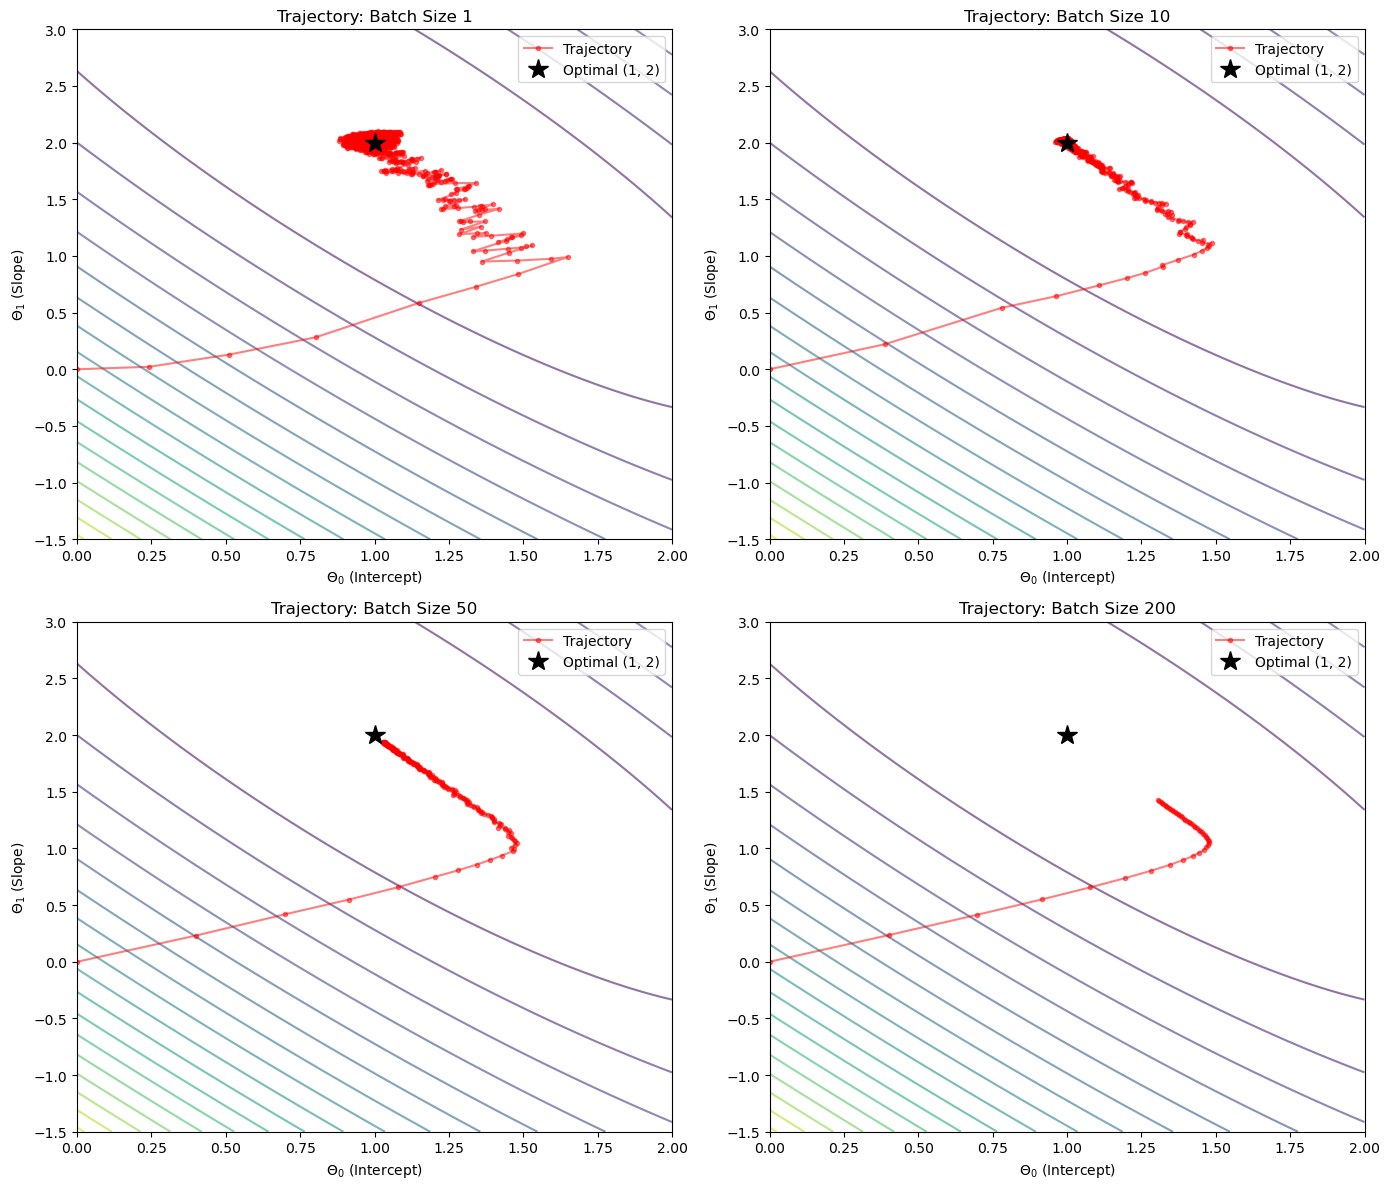

In [24]:
#Parameter Trajectory in 2D Space
# Create a grid of theta values for the contour plot
t0_vals = np.linspace(0, 2, 100)
t1_vals = np.linspace(-1.5, 3, 100)
T0, T1 = np.meshgrid(t0_vals, t1_vals)
Z = np.zeros_like(T0)

# Calculate loss for every point on the grid
for i in range(T0.shape[0]):
    for j in range(T0.shape[1]):
        t = np.array([[T0[i, j]], [T1[i, j]]])
        Z[i, j] = compute_mse_loss(X_b, y, t)

# Plot trajectories
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, bs in enumerate(batch_sizes):
    ax = axes[idx]
    
    # Contour plot of the loss landscape
    ax.contour(T0, T1, Z, levels=20, cmap='viridis', alpha=0.6)
    
    # Plot the optimization path
    # We take a subset of points for SGD to avoid overcrowding the plot
    thetas = results[bs]['theta']
    
    # Plotting logic:
    # For SGD (bs=1), plot every 50th step to see the noise but keep it renderable
    # For GD (bs=200), plot every step

    bs_frequncies = {1 : 50, 10:10}

    step_freq = 1#bs_frequncies.get(bs, 1)
        
    ax.plot(thetas[::step_freq, 0], thetas[::step_freq, 1], 'r.-', alpha=0.5, label='Trajectory')
    ax.plot(1, 2, 'k*', markersize=15, label='Optimal (1, 2)') # The true optimum
    ax.set_title(f'Trajectory: Batch Size {bs}')
    ax.set_xlabel(r'$\Theta_0$ (Intercept)')
    ax.set_ylabel(r'$\Theta_1$ (Slope)')
    ax.legend()

plt.tight_layout()
plt.show()


## 5. Discussion

### **1. Why GD is smooth but slow for large $N$**

**Smoothness:** In Full Gradient Descent ($N\_{batch} = N$), the gradient is calculated using the average error over the **entire dataset**. This computed gradient is an exact representation of the steepest descent direction for the global loss function. Because there is no sampling noise, the path it takes is deterministic and smooth, leading directly toward the local minimum without jittering.

**Slowness:** The "slowness" usually refers to computational cost per step. For every single update of the parameters $\Theta$, the algorithm must compute predictions and errors for all $N$ data points. If $N$ is very large (e.g., millions), a single step becomes computationally expensive. While it takes fewer *steps* to converge than SGD, each step takes much longer to compute.

### **2. Why SGD is noisy but progresses faster**

**Noise:** In Stochastic Gradient Descent ($N\_{batch} = 1$), the gradient is estimated using only **one** data point. This single point is a "noisy" approximation of the true gradient. A specific data point might pull the model in a direction that minimizes the error for *that specific point*, which might not be the direction that minimizes the error for the whole dataset. This causes the "zigzag" or noisy trajectory seen in the plots.

**Speed:** SGD "progresses faster" in terms of iteration frequency. Since it only processes one sample to make an update, it can perform thousands of updates in the time it takes full GD to perform one. Often, this allows the model to get near the optimal solution very quickly, even before the entire dataset has been seen once (i.e., within the first epoch).

### **3. How batch size affects noise level and convergence stability**

Batch size acts as a slider between the stability of GD and the speed of SGD.

- **Small Batch (e.g., 1 or 10):** High noise. The variance of the gradient estimate is high ($\text{Var}(\nabla) \propto \frac{1}{N\_{batch}}$). This noise can actually be beneficial, helping the model escape shallow local minima (though less relevant in convex linear regression). However, it requires a smaller learning rate to settle into the minimum exactly.
- **Large Batch (e.g., 50 or 200):** Low noise. As the batch size increases, the gradient estimate approaches the true gradient. The trajectory becomes smoother and more stable, allowing for larger learning rates, but the computational cost per update increases.

# Exercise 2


In [25]:
# --- 1. Setup Data (Synthetic Linear Regression) ---
np.random.seed(42) # Ensure reproducibility

N = 200  # Total dataset size
X = np.random.rand(N, 1)
true_theta = 3.0
noise = np.random.randn(N, 1) * 0.5
y = true_theta * X + noise

# --- 2. Define Gradient Function ---
def compute_gradient(theta, X_batch, y_batch):
    """
    Computes the gradient of the MSE loss with respect to theta.
    Gradient of MSE = (2/m) * X^T * (X*theta - y)
    """
    m = len(y_batch)
    prediction = X_batch.dot(theta)
    error = prediction - y_batch
    gradient = (2/m) * X_batch.T.dot(error)
    return gradient

# Check shapes
print(f"Total Dataset Size (N): {N}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Total Dataset Size (N): 200
X shape: (200, 1), y shape: (200, 1)


In [26]:
# --- 3. Run the Experiment ---

# Fix a parameter vector Theta (Randomly initialized or fixed constant)
# We are NOT updating this theta, just measuring gradient variance at this point.
Theta_fixed = np.array([[0.5]]) 

batch_sizes = [1, 5, 20, N] # N_batch values
num_samples = 100 # Number of times to compute gradient per batch size
variances = []

print(f"Fixed Theta: {Theta_fixed[0][0]}\n")

for b_size in batch_sizes:
    gradients = []
    
    # Compute gradient 100 times for randomly sampled batches
    for _ in range(num_samples):
        # 1. Randomly sample indices for the mini-batch
        indices = np.random.choice(N, b_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]
        
        # 2. Compute gradient
        g_k = compute_gradient(Theta_fixed, X_batch, y_batch)
        gradients.append(g_k)
    
    gradients = np.array(gradients) # Shape: (100, 1, 1)
    
    # 3. Compute Empirical Variance
    # Formula: Var(g) = (1/100) * sum( || g_k - g_bar ||^2 )
    
    g_bar = np.mean(gradients, axis=0) # Average gradient
    
    # Calculate squared norms of differences
    # Since this is 1D, norm squared is just (g_k - g_bar)^2
    squared_diffs = np.sum((gradients - g_bar) ** 2, axis=0) 
    
    # Average the squared diffs to get variance
    variance = np.sum(squared_diffs) / num_samples
    variances.append(variance)
    
    print(f"Batch Size: {b_size:3d} | Empirical Variance: {variance:.4f}")

Fixed Theta: 0.5

Batch Size:   1 | Empirical Variance: 2.7079
Batch Size:   5 | Empirical Variance: 0.4376
Batch Size:  20 | Empirical Variance: 0.1159
Batch Size: 200 | Empirical Variance: 0.0000


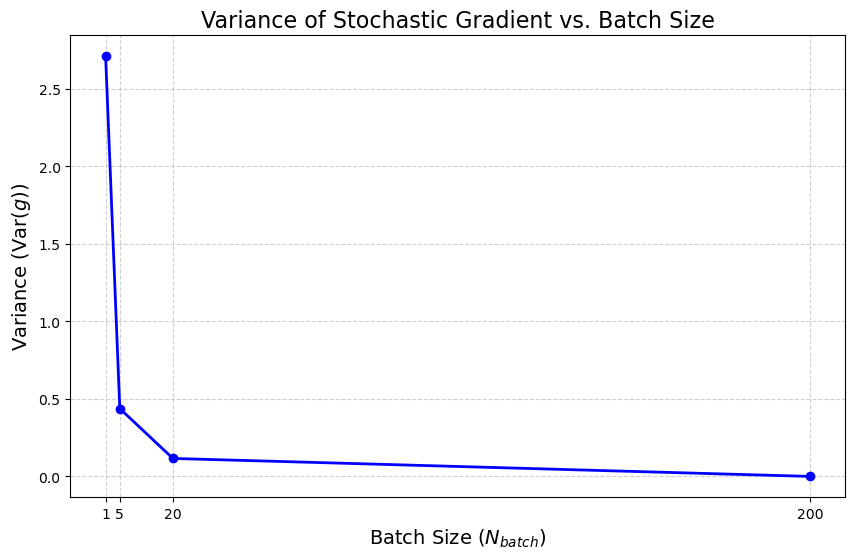

In [27]:
# --- 4. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, variances, marker='o', linestyle='-', color='b', linewidth=2)
plt.title(r'Variance of Stochastic Gradient vs. Batch Size', fontsize=16)
plt.xlabel(r'Batch Size ($N_{batch}$)', fontsize=14)
plt.ylabel(r'Variance ($\text{Var}(g)$)', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.xticks(batch_sizes) # Ensure x-axis shows our specific batch sizes
plt.show()


# Exercise 3

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the Loss Function
def loss_function(theta):
    """
    Computes the value of the loss function at a given point theta = [theta1, theta2].
    """
    t1, t2 = theta[0], theta[1]
    # Formula: (t1^2 - 1)^2 + 10*(t2 - t1^2)^2
    return (t1**2 - 1)**2 + 10 * (t2 - t1**2)**2

# 2. Define the Gradient
def gradient(theta):
    """
    Computes the gradient vector [dL/dtheta1, dL/dtheta2] at a given point.
    """
    t1, t2 = theta[0], theta[1]
    
    # Derived partial derivative for theta1
    # dL/dt1 = 4*t1*(t1^2 - 1) - 40*t1*(t2 - t1^2)
    grad_t1 = 4 * t1 * (t1**2 - 1) - 40 * t1 * (t2 - t1**2)
    
    # Derived partial derivative for theta2
    # dL/dt2 = 20*(t2 - t1^2)
    grad_t2 = 20 * (t2 - t1**2)
    
    return np.array([grad_t1, grad_t2])



In [29]:
def sgd_2d(start_theta, learning_rate, noise_variance, n_steps):
    """
    Performs Stochastic Gradient Descent updates in 2D.
    
    Parameters:
    - start_theta: Starting coordinate [x, y]
    - learning_rate: The step size (eta)
    - noise_variance: The variance of the noise (sigma^2)
    - n_steps: Number of iterations to run
    
    Returns:
    - trajectory: A numpy array of shape (n_steps+1, 2) containing the path taken.
    """
    # Initialize the trajectory list with the starting point
    theta = np.array(start_theta, dtype=float)
    trajectory = [theta.copy()]
    
    # Calculate standard deviation (sigma) from variance (sigma^2)
    # We enforce that noise_variance < 1 as per instructions, but handled by user input
    noise_std_dev = np.sqrt(noise_variance)
    
    for _ in range(n_steps):
        # 1. Compute the true gradient at current position
        true_grad = gradient(theta)
        
        # 2. Generate Gaussian noise vector
        # We need 2 noise values (one for each dimension)
        # mean=0, scale=sigma
        noise = np.random.normal(loc=0.0, scale=noise_std_dev, size=2)
        
        # 3. Create the "gradient batch" gk (True Gradient + Noise)
        gk = true_grad + noise
        
        # 4. Update Theta: theta_new = theta_old - learning_rate * gk
        theta = theta - learning_rate * gk
        
        # Append new position to history
        trajectory.append(theta.copy())
        
    return np.array(trajectory)

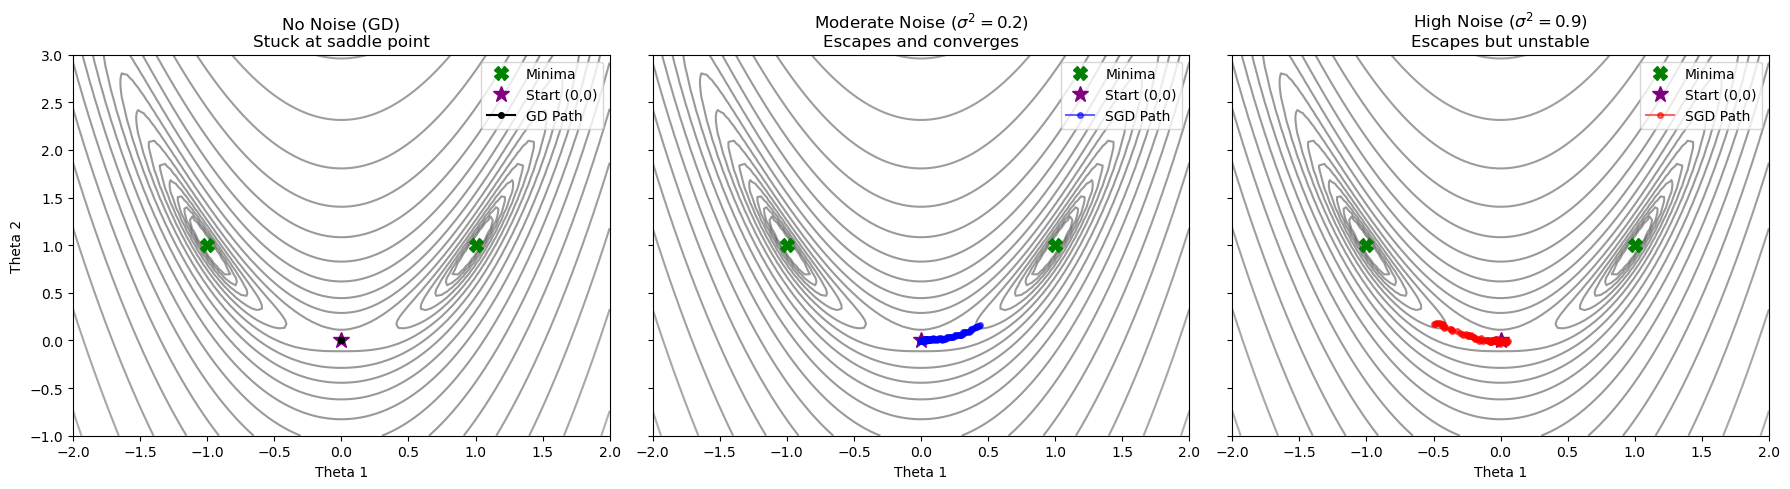

In [30]:
# --- Setup Grid ---
x_vals = np.linspace(-2.0, 2.0, 100)
y_vals = np.linspace(-1.0, 3.0, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = (X**2 - 1)**2 + 10 * (Y - X**2)**2

# --- Run Experiments ---

# CHANGE 1: Start at (0,0).
# (0,0) is a saddle point where gradient is 0. 
# Pure GD should get stuck here. SGD should escape.
start_pos = [0.0, 0.0] 
steps = 100
lr = 0.01

# Run the 3 scenarios
traj_no_noise = sgd_2d(start_pos, lr, noise_variance=0.0, n_steps=steps)
traj_med_noise = sgd_2d(start_pos, lr, noise_variance=0.2, n_steps=steps)
traj_high_noise = sgd_2d(start_pos, lr, noise_variance=0.9, n_steps=steps)

# --- Improved Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Helper function to plot background on all subplots
def plot_background(ax):
    ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='gray', alpha=0.4)
    ax.plot([1, -1], [1, 1], 'X', color='green', markersize=10, label='Minima') # True Minima
    ax.plot(start_pos[0], start_pos[1], '*', color='purple', markersize=12, label='Start (0,0)')
    ax.set_xlabel('Theta 1')

# Plot 1: No Noise
plot_background(axes[0])
axes[0].plot(traj_no_noise[:, 0], traj_no_noise[:, 1], 'o-', color='black', markersize=4, label='GD Path')
axes[0].set_title('No Noise (GD)\nStuck at saddle point')
axes[0].set_ylabel('Theta 2')
axes[0].legend()

# Plot 2: Moderate Noise
plot_background(axes[1])
axes[1].plot(traj_med_noise[:, 0], traj_med_noise[:, 1], 'o-', color='blue', markersize=4, alpha=0.6, label='SGD Path')
axes[1].set_title('Moderate Noise ($\sigma^2=0.2$)\nEscapes and converges')
axes[1].legend()

# Plot 3: High Noise
plot_background(axes[2])
axes[2].plot(traj_high_noise[:, 0], traj_high_noise[:, 1], 'o-', color='red', markersize=4, alpha=0.6, label='SGD Path')
axes[2].set_title('High Noise ($\sigma^2=0.9$)\nEscapes but unstable')
axes[2].legend()

plt.tight_layout()
plt.show()

# Exercise 4

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load and Preprocess Data ---

# Try to load the dataset. If it doesn't exist, we create a dummy one so the code runs.

df = pd.read_csv('data/insurance.csv')
print("Dataset 'insurance.csv' loaded successfully.")


# Select features and target
features = ['age', 'bmi', 'children']
target = 'charges'

X_raw = df[features].values
y_raw = df[target].values

# --- Standardization ---
# We standardize (Z-score normalization) to ensure gradients don't explode
# Formula: z = (x - mean) / std

# Standardize Features
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_scaled = (X_raw - X_mean) / X_std

# Standardize Target
y_mean = y_raw.mean()
y_std = y_raw.std()
y_scaled = (y_raw - y_mean) / y_std

# --- Add Bias Column ---
# We add a column of 1s to X so the dot product Theta * X includes the intercept automatically.
N = X_scaled.shape[0]
bias_col = np.ones((N, 1))
X_final = np.hstack((bias_col, X_scaled))

print(f"Data Shape: X={X_final.shape}, y={y_scaled.shape}")
print("First 3 rows of processed X:\n", X_final[:3])

Dataset 'insurance.csv' loaded successfully.
Data Shape: X=(1338, 4), y=(1338,)
First 3 rows of processed X:
 [[ 1.         -1.43876426 -0.45332    -0.90861367]
 [ 1.         -1.50996545  0.5096211  -0.07876719]
 [ 1.         -0.79795355  0.38330685  1.58092576]]


## Implementing the Solver

In [32]:
def compute_loss(X, y, theta):
    """Mean Squared Error: (1/N) * sum((y_pred - y_true)^2)"""
    N = len(y)
    predictions = X @ theta
    errors = predictions - y
    return (1 / N) * np.sum(errors ** 2)

def compute_gradient(X, y, theta):
    """
    Computes the gradient of MSE for a given X and y.
    Formula: (2/N) * X.T * (X*theta - y)
    """
    N = len(y)
    predictions = X @ theta
    errors = predictions - y
    # The gradient vector
    grad = (2 / N) * (X.T @ errors)
    return grad

def train_linear_regression(X, y, batch_size, lr=0.01, epochs=50):
    """
    Trains Linear Regression using Mini-batch SGD (or Full GD if batch_size=N).
    """
    N, D = X.shape
    
    # Initialize Theta randomly (small values)
    np.random.seed(42) # For reproducibility
    theta = np.random.randn(D) * 0.1
    
    # History for plotting
    loss_history = []
    grad_norm_history = []
    
    # Training Loop
    for epoch in range(epochs):
        
        # 1. Shuffle data at the start of each epoch (Crucial for SGD!)
        indices = np.arange(N)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # 2. Mini-batch updates
        # If batch_size == N, this loop runs exactly once (Full GD)
        for i in range(0, N, batch_size):
            # Create batch
            X_batch = X_shuffled[i : i+batch_size]
            y_batch = y_shuffled[i : i+batch_size]
            
            # Compute gradient just for this batch
            grad = compute_gradient(X_batch, y_batch, theta)
            
            # Update parameters
            theta = theta - lr * grad
            
        # 3. End of Epoch Logging
        # We compute the loss and FULL gradient norm on the WHOLE dataset
        # to compare convergence fairly across methods.
        current_loss = compute_loss(X, y, theta)
        full_grad = compute_gradient(X, y, theta)
        grad_norm = np.linalg.norm(full_grad) # L2 norm
        
        loss_history.append(current_loss)
        grad_norm_history.append(grad_norm)
        
    return theta, loss_history, grad_norm_history

## Running the Experiments

In [33]:
# Configuration
EPOCHS = 50
LR = 0.01 # Fixed learning rate as requested
N_SAMPLES = X_final.shape[0]

print("Starting training...")

# 1. Full GD (Batch size = Total Samples)
theta_gd, loss_gd, norm_gd = train_linear_regression(
    X_final, y_scaled, batch_size=N_SAMPLES, lr=LR, epochs=EPOCHS
)

# 2. SGD (Batch size = 1)
theta_sgd1, loss_sgd1, norm_sgd1 = train_linear_regression(
    X_final, y_scaled, batch_size=1, lr=LR, epochs=EPOCHS
)

# 3. SGD (Batch size = 10)
theta_sgd10, loss_sgd10, norm_sgd10 = train_linear_regression(
    X_final, y_scaled, batch_size=10, lr=LR, epochs=EPOCHS
)

# 4. SGD (Batch size = 50)
theta_sgd50, loss_sgd50, norm_sgd50 = train_linear_regression(
    X_final, y_scaled, batch_size=50, lr=LR, epochs=EPOCHS
)

print("Training complete.")

# Report Final Parameters for comparison
print("\nFinal Parameters (Theta):")
print(f"Full GD:  {np.round(theta_gd, 3)}")
print(f"SGD (1):  {np.round(theta_sgd1, 3)}")
print(f"SGD (10): {np.round(theta_sgd10, 3)}")
print(f"SGD (50): {np.round(theta_sgd50, 3)}")

Starting training...
Training complete.

Final Parameters (Theta):
Full GD:  [0.018 0.174 0.141 0.095]
SGD (1):  [-0.003  0.319  0.292  0.078]
SGD (10): [0.033 0.28  0.227 0.042]
SGD (50): [0.003 0.278 0.174 0.05 ]


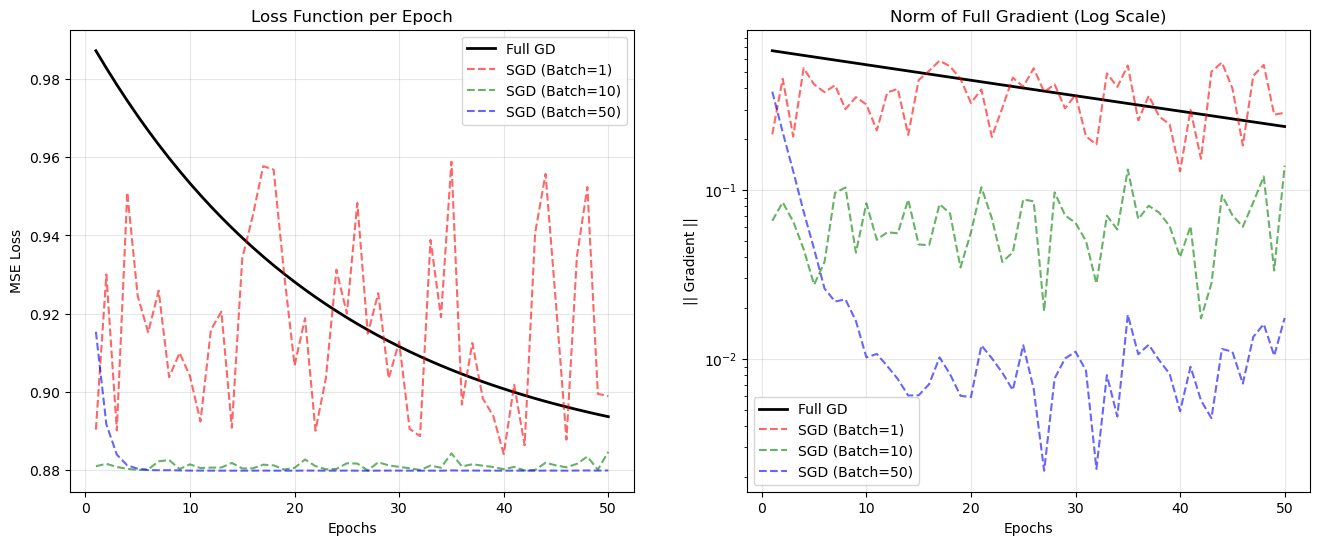

In [34]:
epochs_range = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Loss vs Epoch ---
ax1.plot(epochs_range, loss_gd, 'k-', linewidth=2, label='Full GD')
ax1.plot(epochs_range, loss_sgd1, 'r--', alpha=0.6, label='SGD (Batch=1)')
ax1.plot(epochs_range, loss_sgd10, 'g--', alpha=0.6, label='SGD (Batch=10)')
ax1.plot(epochs_range, loss_sgd50, 'b--', alpha=0.6, label='SGD (Batch=50)')

ax1.set_title('Loss Function per Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Gradient Norm vs Epoch ---
# We use log scale because norms can vary widely
ax2.plot(epochs_range, norm_gd, 'k-', linewidth=2, label='Full GD')
ax2.plot(epochs_range, norm_sgd1, 'r--', alpha=0.6, label='SGD (Batch=1)')
ax2.plot(epochs_range, norm_sgd10, 'g--', alpha=0.6, label='SGD (Batch=10)')
ax2.plot(epochs_range, norm_sgd50, 'b--', alpha=0.6, label='SGD (Batch=50)')

ax2.set_yscale('log')
ax2.set_title('Norm of Full Gradient (Log Scale)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('|| Gradient ||')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()